In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.data import Dataset
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow import GradientTape, function, random, ones_like, zeros_like

c:\Users\yosef\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
x_train_gray = np.load("x_train_grayN2.npy")
x_train_color = np.load("x_train_colorN2.npy")
x_test_gray = np.load("x_test_grayN2.npy")
x_test_color = np.load("x_test_colorN2.npy")

In [4]:
x_train_gray = (x_train_gray * 2.0) - 1.0  # [0,1] -> [-1,1]
x_train_color = (x_train_color * 2.0) - 1.0

In [5]:
print("x_train_gray shape:", x_train_gray.shape)  # Expected: (N, 256, 256, 1) or (N, 128, 128, 1)
print("x_train_color shape:", x_train_color.shape) # Expected: (N, 256, 256, 3) or (N, 128, 128, 3)

print("x_test_gray shape:", x_test_gray.shape)  # Expected: (N, 256, 256, 1) or (N, 128, 128, 1)
print("x_test_color shape:", x_test_color.shape) # Expected: (N, 256, 256, 3) or (N, 128, 128, 3)

x_train_gray shape: (2350, 256, 256, 1)
x_train_color shape: (2350, 256, 256, 3)
x_test_gray shape: (124, 256, 256, 1)
x_test_color shape: (124, 256, 256, 3)


In [6]:
train_dataset = Dataset.from_tensor_slices(
    (x_train_gray, x_train_color)
).shuffle(buffer_size=1000).batch(16)

test_dataset = Dataset.from_tensor_slices(
    (x_test_gray, x_test_color)
).shuffle(buffer_size=1000).batch(16)

In [7]:
# Check shapes before batching
print(next(iter(train_dataset.unbatch()))[0].shape)  # Should be (256, 256, 1)
print(next(iter(train_dataset.unbatch()))[1].shape)  # Should be (256, 256, 3)

(256, 256, 1)
(256, 256, 3)


In [8]:
def build_generator(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Downsample (Encoder)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu')(inputs)  # 128x128
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='leaky_relu')(x)      # 64x64
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='leaky_relu')(x)      # 32x32
    
    # Upsample (Decoder) with skip connections
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)   # 64x64
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)    # 128x128
    x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)    # 256x256
    
    # Final output layer
    outputs = layers.Conv2D(3, 4, padding='same', activation='tanh')(x)                   # 256x256x3
    
    return Model(inputs, outputs)

In [9]:
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='leaky_relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='leaky_relu')(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same', activation='leaky_relu')(x)
    
    outputs = layers.Conv2D(1, 4, strides=1, padding='same', activation='sigmoid')(x)
    return Model(inputs, outputs)

In [10]:


# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Losses
bce_loss = BinaryCrossentropy(from_logits=False)
mae_loss = MeanAbsoluteError()

def generator_loss(fake_output, fake_images, real_images):
    # Adversarial loss
    adv_loss = bce_loss(ones_like(fake_output), fake_output)
    # Pixel-wise loss
    l1_loss = mae_loss(real_images, fake_images)
    return adv_loss + 100 * l1_loss  # Weight L1 loss heavily

def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(ones_like(real_output), real_output)
    fake_loss = bce_loss(zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [11]:
print(generator.summary())
print(discriminator.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,723 (5.14 MB)

 Trainable params: 1,346,723 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# Optimizers
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)

@function
def train_step(grayscale_input, real_color):
    with GradientTape() as gen_tape, GradientTape() as disc_tape:
        # Generate fake color images (will be 3 channels)
        fake_color = generator(grayscale_input, training=True)
        
        # Discriminator gets:
        # - Real color images (3 channels)
        # - Fake color images (3 channels)
        real_output = discriminator(real_color, training=True)  # real_color is (256,256,3)
        fake_output = discriminator(fake_color, training=True)  # fake_color is (256,256,3)
        
        # Calculate losses
        gen_loss = generator_loss(fake_output, fake_color, real_color)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Update weights
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

# Training loop
for epoch in range(21):
    for batch_gray, batch_color in train_dataset:
        train_step(batch_gray, batch_color)
    
    # # Optional: Validate on test data
    # for test_gray, test_color in test_dataset:
    #     # Generate test predictions
    #     fake_test = generator(test_gray, training=False)
    #     # Calculate metrics (e.g., PSNR, SSIM)

    # Save checkpoints (optional)
    if epoch % 10 == 0:
        generator.save(f'GAN_colorizationN2.keras', overwrite=True)

In [7]:
generator = load_model("GAN_colorizationN2.keras")


In [8]:
predictions = generator.predict(x_test_gray)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step


In [9]:
def enhance_colors(image, saturation_factor=2.5, contrast=1.4):
    """Boost saturation and contrast of generated image"""
    # Convert from [-1,1] to [0,255]
    image = ((image + 1) * 127.5).astype('uint8')
    
    # HSV transformation for saturation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype('float32')
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation_factor, 0, 255)
    saturated = cv2.cvtColor(hsv.astype('uint8'), cv2.COLOR_HSV2RGB)
    
    # Contrast adjustment
    final = cv2.convertScaleAbs(saturated, alpha=contrast, beta=0)
    return final

In [16]:
def display_results(grayscale, predicted, original):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.title('Original')
    plt.imshow(original)
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title('Grayscale')
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title('Prediction')
    plt.imshow((predicted + 1) / 2)  # Display in [0,1] range
    plt.axis('off')
    
    plt.show()

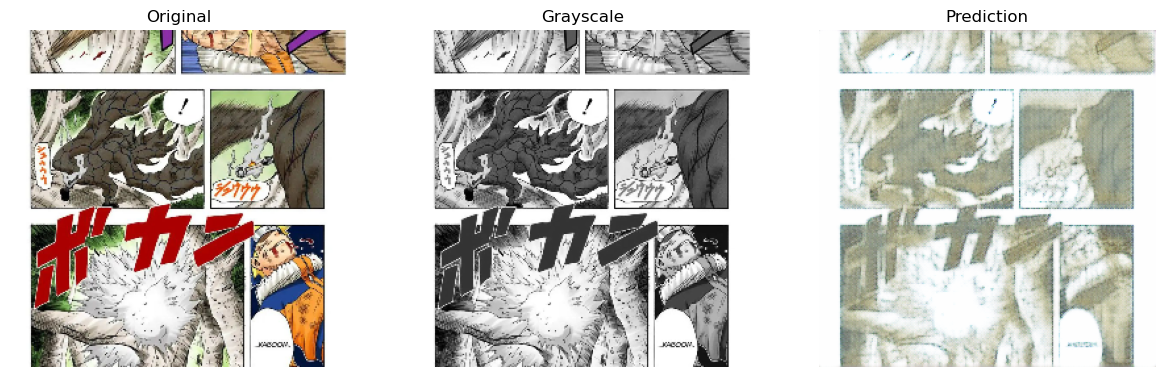

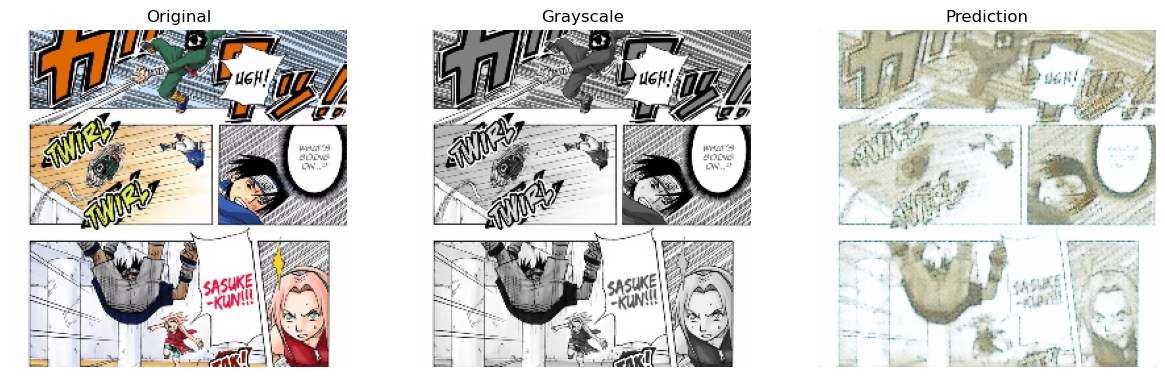

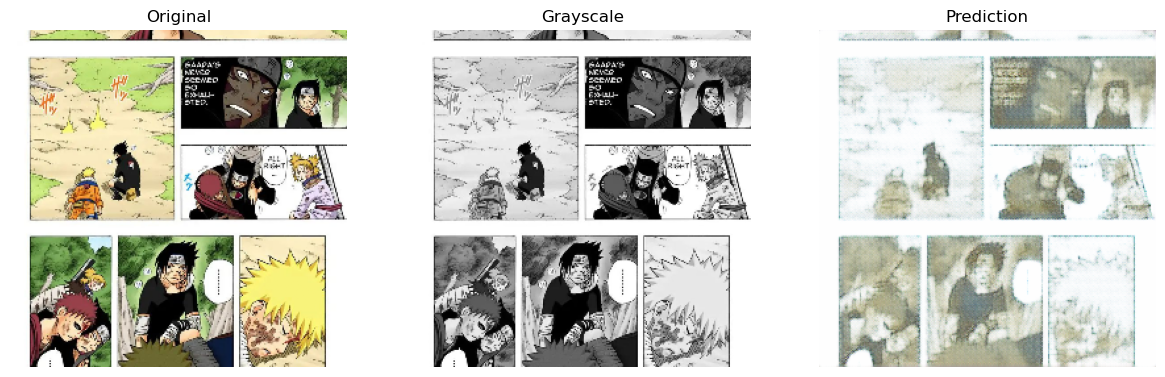

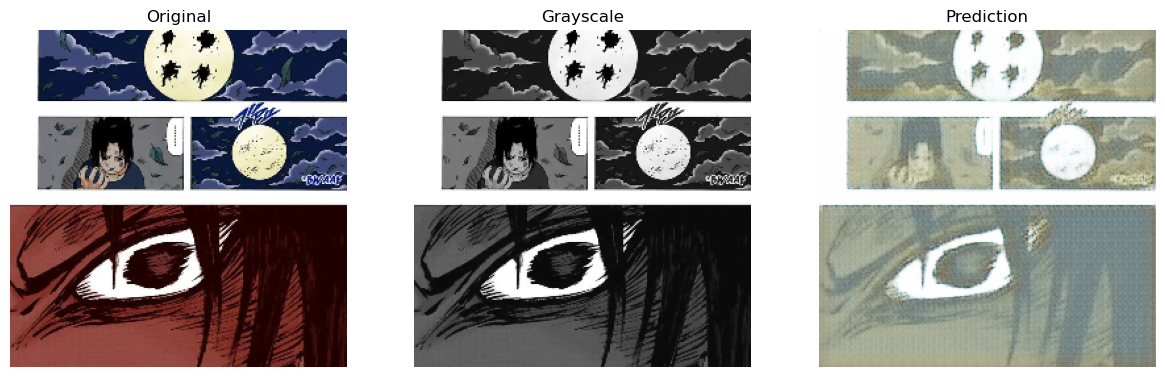

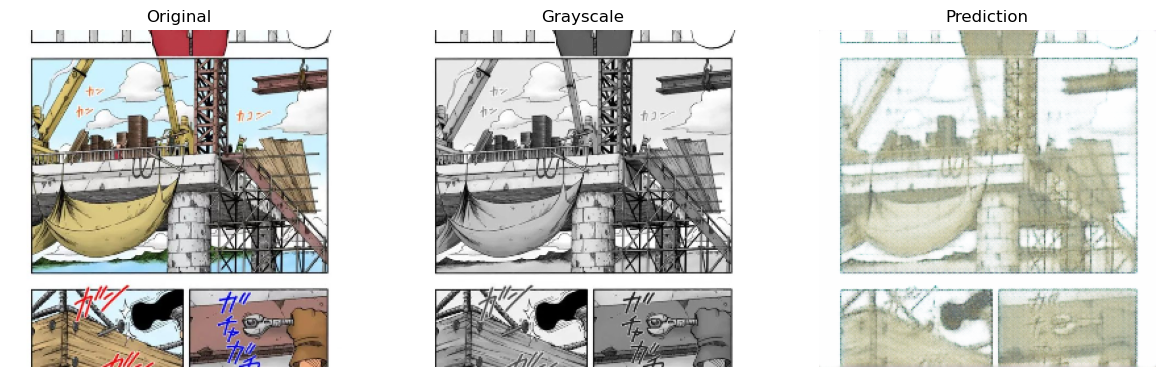

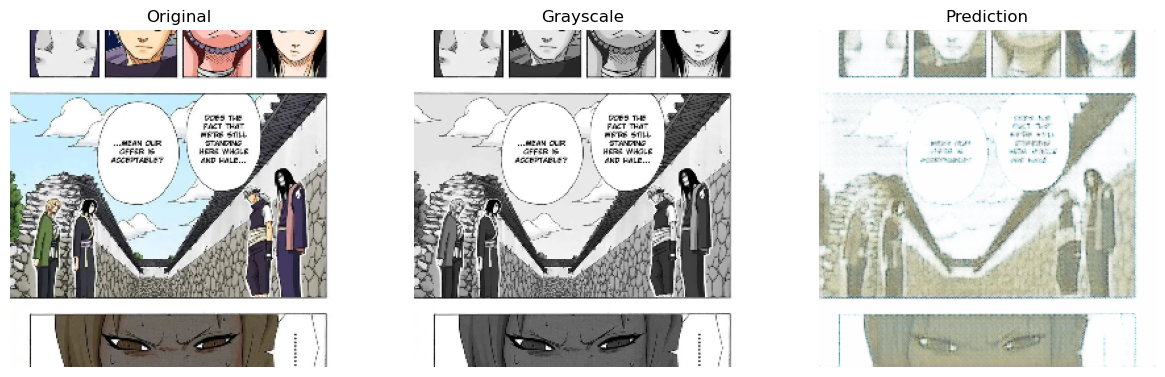

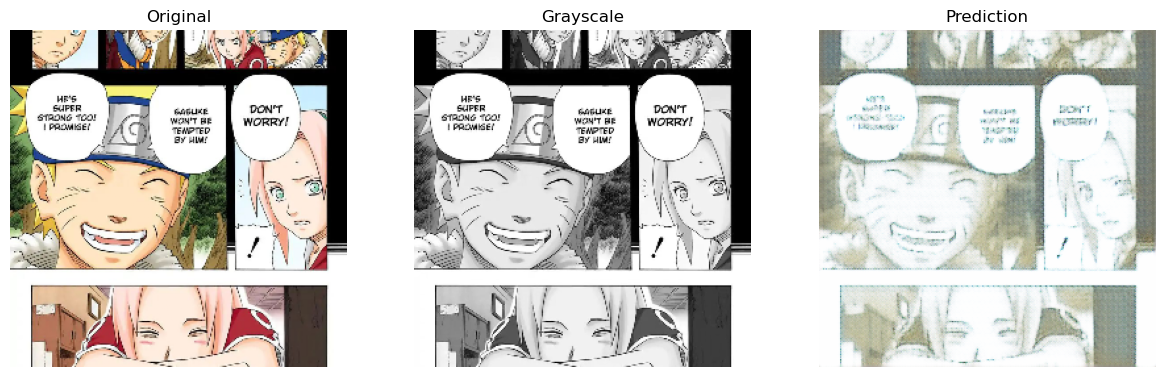

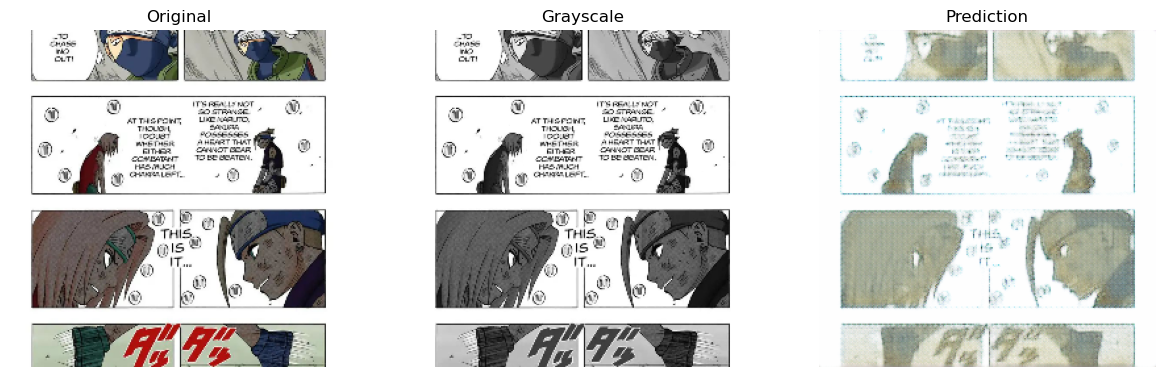

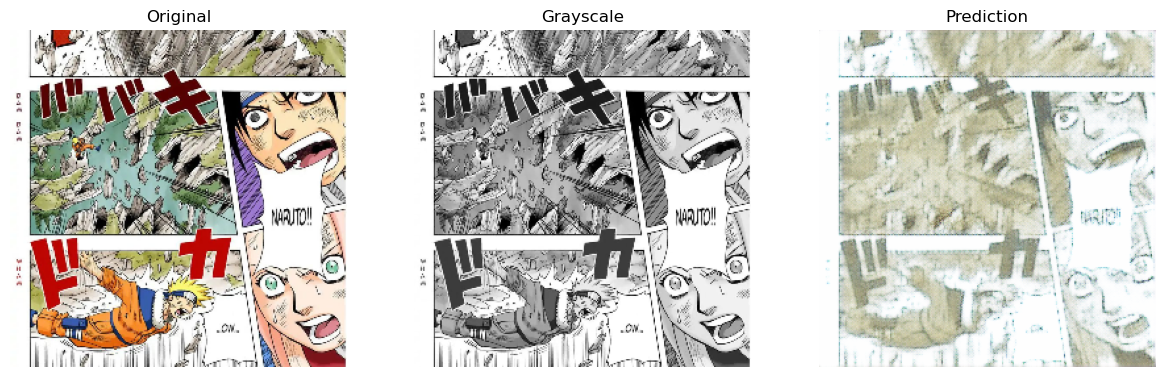

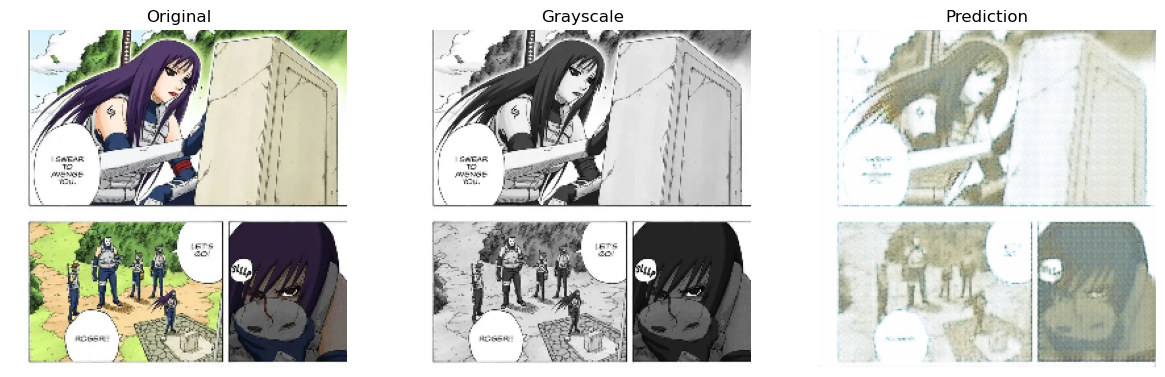

In [17]:
for i in range(10):
    display_results(
        grayscale=x_test_gray[i],
        predicted=predictions[i],
        original=x_test_color[i],  # Assuming data was in [-1,1]
    )